In [35]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import os

In [36]:
data_path = "data/garbage-dataset"
h = 224
w = 224
counter = 0

X, y = [], []

In [37]:
classes = os.listdir(data_path)
print(classes)
NUM_CLASSES = len(classes)
print(NUM_CLASSES)

['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']
10


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

train_transform = transforms.Compose([
    
    transforms.Resize((h, w)),   
    
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.RandomRotation(degrees=15),              
    transforms.ToTensor(),                     
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # Standar normalisasi ImageNet
                         std=[0.229, 0.224, 0.225])
])


dataset = datasets.ImageFolder(root=data_path, transform=train_transform)

# print(images.shape) 

In [39]:
from torch.utils.data import random_split
import torch

total_count = len(dataset)
train_count = int(0.7 * total_count)
val_count = int(0.15*total_count)
test_count = total_count - train_count - val_count

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_count, val_count, test_count])

print(f"Total Data : {total_count}")
print(f"Data Train : {len(train_dataset)} ({len(train_dataset)/total_count:.1%})")
print(f"Data Val   : {len(val_dataset)} ({len(val_dataset)/total_count:.1%})")
print(f"Data Test  : {len(test_dataset)} ({len(test_dataset)/total_count:.1%})")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

train_indices = train_dataset.indices

Total Data : 19762
Data Train : 13833 (70.0%)
Data Val   : 2964 (15.0%)
Data Test  : 2965 (15.0%)


In [40]:
import torch

# Cek apakah CUDA (NVIDIA GPU) tersedia
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Training akan menggunakan: {device}")

Training akan menggunakan: cuda


In [41]:
import torch
print("Versi PyTorch:", torch.__version__)
print("Cuda Available:", torch.cuda.is_available())

Versi PyTorch: 2.5.1+cu121
Cuda Available: True


In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

for param in model.parameters():
    param.requires_grad = False

in_features = model.fc.in_features
model.fc = nn.Linear(in_features, NUM_CLASSES) 


In [43]:
import torch
import numpy as np
from sklearn.utils import class_weight

y_train = [dataset.targets[i] for i in train_indices]

y_train_np = np.array(y_train).astype(int)

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_np),
    y=y_train_np
)

weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

print("Bobot per kelas:", weights_tensor)

criterion = nn.CrossEntropyLoss(weight=weights_tensor)

optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)

Bobot per kelas: tensor([2.1023, 2.0493, 1.0560, 0.3740, 0.6375, 1.9566, 1.1723, 1.0075, 0.9895,
        2.0864], device='cuda:0')


In [ ]:
import time
import copy
from sklearn.metrics import f1_score, precision_score, recall_score

model = model.to(device)

num_epochs = 5
best_val_f1 = 0.0 
best_model_wts = copy.deepcopy(model.state_dict())
history = {
    'train_loss': [], 'val_loss': [], 
    'train_acc': [], 'val_acc': [],
    'train_f1': [], 'val_f1': [],
    'train_prec': [], 'val_prec': [],  
    'train_rec': [], 'val_rec': []     
}

print("Mulai Training...")
start_time = time.time()
for epoch in range(num_epochs):
    
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
            dataloader = train_loader
        else:
            model.eval()
            dataloader = val_loader

        running_loss = 0.0
        running_corrects = 0
        
        epoch_all_preds = []
        epoch_all_labels = []

        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            epoch_all_preds.extend(preds.cpu().numpy())
            epoch_all_labels.extend(labels.cpu().numpy())

        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = running_corrects.double() / len(dataloader.dataset)
        epoch_f1 = f1_score(epoch_all_labels, epoch_all_preds, average='macro', zero_division=0)
        epoch_prec = precision_score(epoch_all_labels, epoch_all_preds, average='macro', zero_division=0)
        epoch_rec = recall_score(epoch_all_labels, epoch_all_preds, average='macro', zero_division=0)
        
        if phase == 'train':
            history['train_loss'].append(epoch_loss)
            history['train_acc'].append(epoch_acc.item())
            history['train_f1'].append(epoch_f1)
            history['train_prec'].append(epoch_prec)
            history['train_rec'].append(epoch_rec)
        else:
            history['val_loss'].append(epoch_loss)
            history['val_acc'].append(epoch_acc.item())
            history['val_f1'].append(epoch_f1)
            history['val_prec'].append(epoch_prec)
            history['val_rec'].append(epoch_rec)

            if epoch_f1 > best_val_f1:
                best_val_f1 = epoch_f1
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), 'best_resnet50_model.pth')
                print(f"--> Model Saved! Acc: {epoch_acc:.4f} | F1: {epoch_f1:.4f}")

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Precision: {epoch_prec:.4f} Recall: {epoch_rec:.4f} F1: {epoch_f1:.4f}')
    print()

total_time = time.time() - start_time
print(f"\nSelesai! Total waktu: {total_time:.2f} detik")
print(f"F1 Validasi Terbaik: {best_val_f1:.4f}")

Mulai Training...
Epoch 1/5
----------
train Loss: 0.7287 Acc: 0.8336 Precision: 0.7859 Recall: 0.8116 F1: 0.7965
--> Model Saved! Acc: 0.9035 | F1: 0.8795
val Loss: 0.3978 Acc: 0.9035 Precision: 0.8725 Recall: 0.8916 F1: 0.8795

Epoch 2/5
----------
train Loss: 0.3777 Acc: 0.8982 Precision: 0.8653 Recall: 0.8899 F1: 0.8759
--> Model Saved! Acc: 0.9082 | F1: 0.8854
val Loss: 0.3158 Acc: 0.9082 Precision: 0.8766 Recall: 0.8982 F1: 0.8854

Epoch 3/5
----------
train Loss: 0.3175 Acc: 0.9110 Precision: 0.8826 Recall: 0.9057 F1: 0.8928
--> Model Saved! Acc: 0.9177 | F1: 0.8997
val Loss: 0.2962 Acc: 0.9177 Precision: 0.8933 Recall: 0.9096 F1: 0.8997

Epoch 4/5
----------
train Loss: 0.2824 Acc: 0.9187 Precision: 0.8922 Recall: 0.9123 F1: 0.9012
--> Model Saved! Acc: 0.9248 | F1: 0.9065
val Loss: 0.2628 Acc: 0.9248 Precision: 0.8997 Recall: 0.9145 F1: 0.9065

Epoch 5/5
----------
train Loss: 0.2572 Acc: 0.9255 Precision: 0.9017 Recall: 0.9214 F1: 0.9106
--> Model Saved! Acc: 0.9315 | F1: 0.9

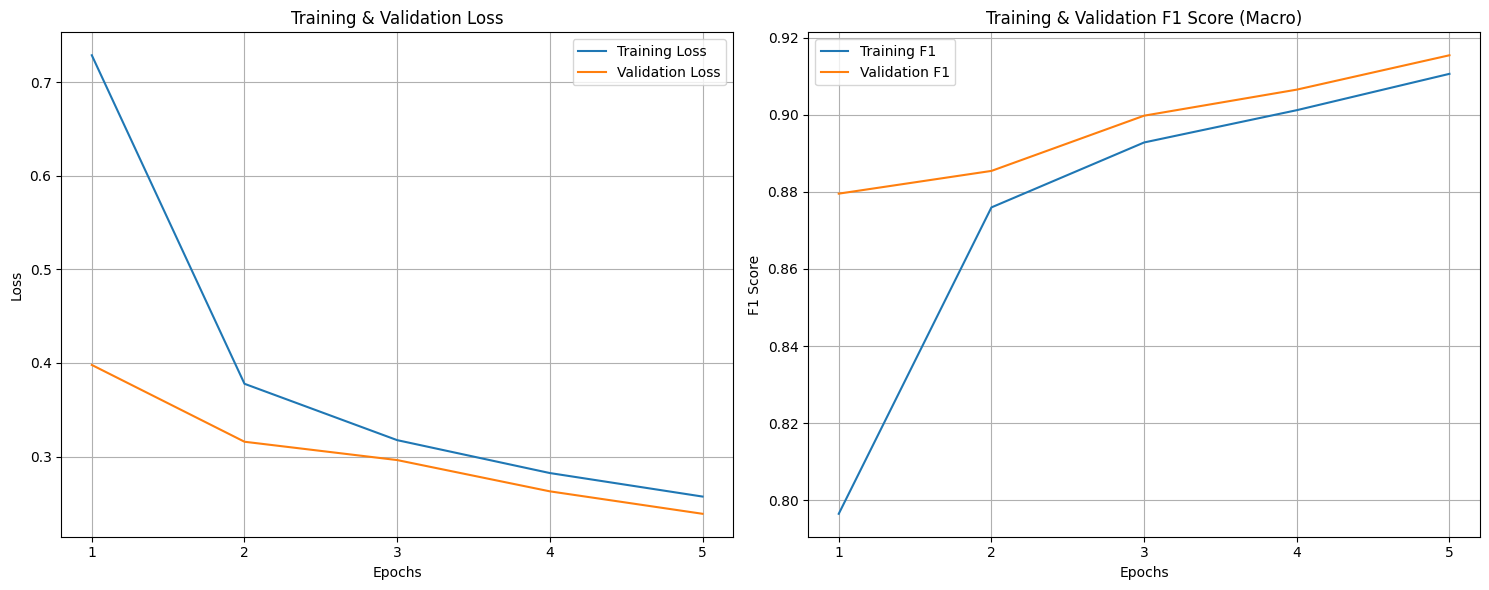

In [45]:
import matplotlib.pyplot as plt

epochs = range(1, len(history['train_loss']) + 1)

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, history['train_loss'], label='Training Loss')
plt.plot(epochs, history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()

plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, history['train_f1'], label='Training F1')
plt.plot(epochs, history['val_f1'], label='Validation F1')
plt.title('Training & Validation F1 Score (Macro)')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.xticks(epochs)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [46]:
model.load_state_dict(torch.load('best_resnet50_model.pth'))

for param in model.layer4.parameters():
    param.requires_grad = True

for param in model.fc.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam([
    {'params': model.layer4.parameters(), 'lr': 1e-5}, # LR Kecil
    {'params': model.fc.parameters(), 'lr': 1e-4}      # LR Sedang
])

C:\Users\hansc\AppData\Local\Temp\ipykernel_12420\1330552766.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_resnet50_model.pth'))

In [ ]:
num_epochs = 10
best_val_f1 = 0.0 
best_model_wts = copy.deepcopy(model.state_dict())
history2 = {
    'train_loss': [], 'val_loss': [], 
    'train_acc': [], 'val_acc': [],
    'train_f1': [], 'val_f1': [],
    'train_prec': [], 'val_prec': [],  
    'train_rec': [], 'val_rec': []     
}

print("Mulai Training...")
start_time = time.time()
for epoch in range(num_epochs):
    
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
            dataloader = train_loader
        else:
            model.eval()
            dataloader = val_loader

        running_loss = 0.0
        running_corrects = 0
    
        epoch_all_preds = []
        epoch_all_labels = []

        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            epoch_all_preds.extend(preds.cpu().numpy())
            epoch_all_labels.extend(labels.cpu().numpy())

        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = running_corrects.double() / len(dataloader.dataset)
        epoch_f1 = f1_score(epoch_all_labels, epoch_all_preds, average='macro')
        epoch_prec = precision_score(epoch_all_labels, epoch_all_preds, average='macro', zero_division=0)
        epoch_rec = recall_score(epoch_all_labels, epoch_all_preds, average='macro', zero_division=0)

        if phase == 'train':
            history2['train_loss'].append(epoch_loss)
            history2['train_acc'].append(epoch_acc.item())
            history2['train_f1'].append(epoch_f1)
            history2['train_prec'].append(epoch_prec)
            history2['train_rec'].append(epoch_rec)
        else:
            history2['val_loss'].append(epoch_loss)
            history2['val_acc'].append(epoch_acc.item())
            history2['val_f1'].append(epoch_f1)
            history2['val_prec'].append(epoch_prec)
            history2['val_rec'].append(epoch_rec)

            if epoch_f1 > best_val_f1:
                best_val_f1 = epoch_f1
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), 'best_resnet50_model_2.pth')
                print(f"--> Model Saved! Acc: {epoch_acc:.4f} | F1: {epoch_f1:.4f}")

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Precision: {epoch_prec:.4f} Recall: {epoch_rec:.4f} F1: {epoch_f1:.4f}')
    print()

total_time = time.time() - start_time
print(f"\nSelesai! Total waktu: {total_time:.2f} detik")
print(f"F1 Validasi Terbaik: {best_val_f1:.4f}")

Mulai Training...
Epoch 1/10
----------
train Loss: 0.2237 Acc: 0.9334 Precision: 0.9119 Recall: 0.9299 F1: 0.9200
--> Model Saved! Acc: 0.9329 | F1: 0.9187
val Loss: 0.2261 Acc: 0.9329 Precision: 0.9107 Recall: 0.9290 F1: 0.9187

Epoch 2/10
----------
train Loss: 0.1921 Acc: 0.9427 Precision: 0.9239 Recall: 0.9405 F1: 0.9316
--> Model Saved! Acc: 0.9349 | F1: 0.9214
val Loss: 0.2050 Acc: 0.9349 Precision: 0.9146 Recall: 0.9299 F1: 0.9214

Epoch 3/10
----------
train Loss: 0.1677 Acc: 0.9482 Precision: 0.9319 Recall: 0.9480 F1: 0.9394
--> Model Saved! Acc: 0.9460 | F1: 0.9352
val Loss: 0.1851 Acc: 0.9460 Precision: 0.9297 Recall: 0.9419 F1: 0.9352

Epoch 4/10
----------
train Loss: 0.1402 Acc: 0.9574 Precision: 0.9443 Recall: 0.9558 F1: 0.9497
val Loss: 0.1908 Acc: 0.9430 Precision: 0.9252 Recall: 0.9379 F1: 0.9307

Epoch 5/10
----------
train Loss: 0.1259 Acc: 0.9610 Precision: 0.9487 Recall: 0.9606 F1: 0.9543
--> Model Saved! Acc: 0.9497 | F1: 0.9389
val Loss: 0.1749 Acc: 0.9497 Prec

d:\Env\computational_biology\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Env\computational_biology\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\hansc\AppData\Local\Temp\ipykernel_12420\2293429657.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will 

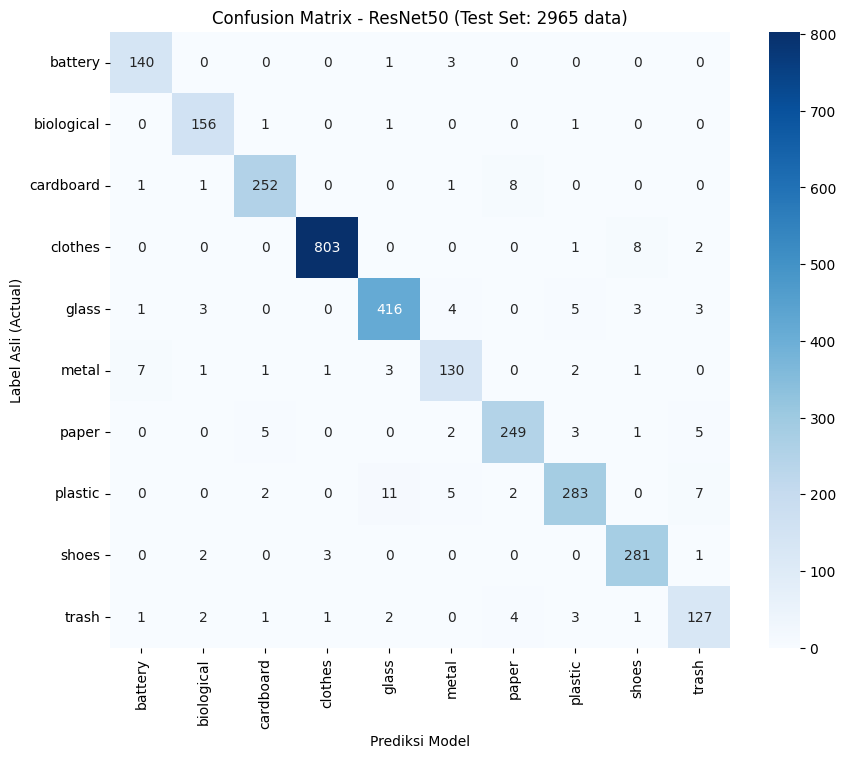


Classification Report:
              precision    recall  f1-score   support

     battery       0.93      0.97      0.95       144
  biological       0.95      0.98      0.96       159
   cardboard       0.96      0.96      0.96       263
     clothes       0.99      0.99      0.99       814
       glass       0.96      0.96      0.96       435
       metal       0.90      0.89      0.89       146
       paper       0.95      0.94      0.94       265
     plastic       0.95      0.91      0.93       310
       shoes       0.95      0.98      0.97       287
       trash       0.88      0.89      0.89       142

    accuracy                           0.96      2965
   macro avg       0.94      0.95      0.94      2965
weighted avg       0.96      0.96      0.96      2965



In [48]:
import torch
import torch.nn as nn
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 1. Setup Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = models.resnet50(pretrained=False) 
num_ftrs = model.fc.in_features          
model.fc = nn.Linear(num_ftrs, NUM_CLASSES)

path_model = 'best_resnet50_model_2.pth'

checkpoint = torch.load(path_model, map_location=device)
model.load_state_dict(checkpoint)
model = model.to(device)
model.eval() 


y_pred = [] 
y_true = [] 

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())


cm = confusion_matrix(y_true, y_pred)

try:
    class_names = test_dataset.dataset.classes
except AttributeError:
    class_names = [str(i) for i in range(NUM_CLASSES)]

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel('Prediksi Model')
plt.ylabel('Label Asli (Actual)')
plt.title(f'Confusion Matrix - ResNet50 (Test Set: {len(y_true)} data)')
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

In [49]:
final_history = {}

for key in history:
    final_history[key] = history[key] + history2[key]

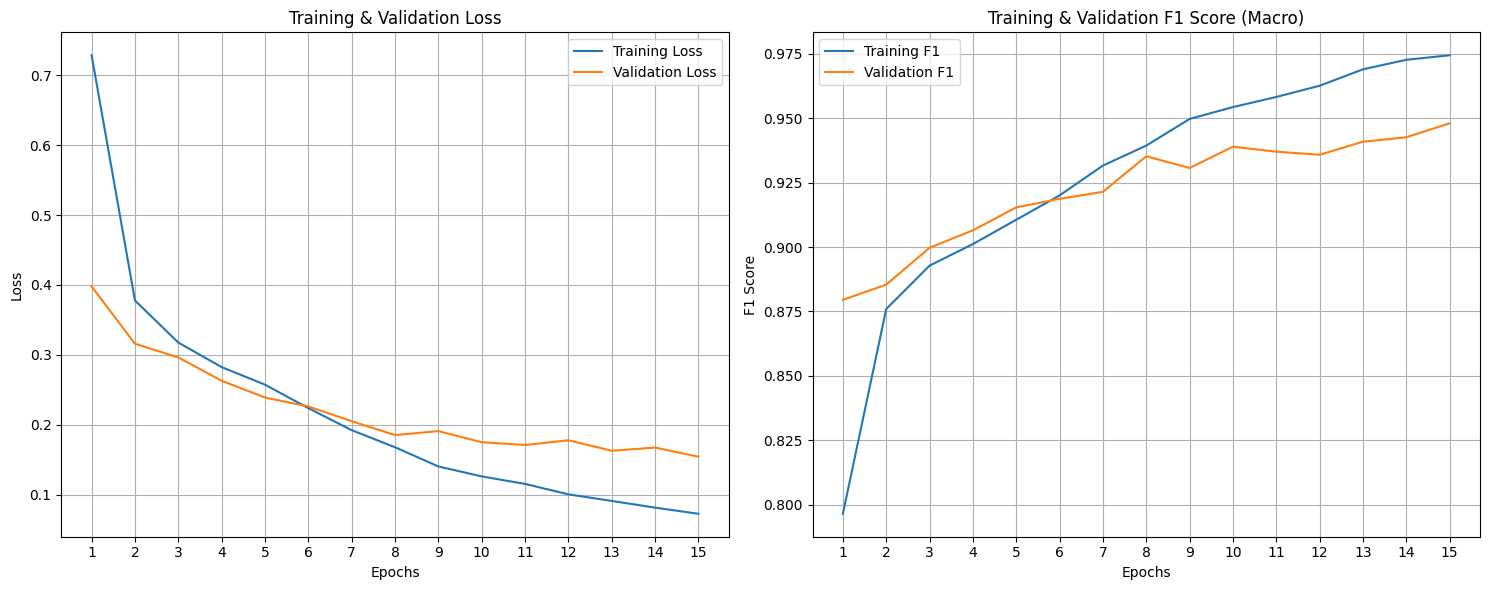

In [50]:
import matplotlib.pyplot as plt

epochs = range(1, len(final_history['train_loss']) + 1)

plt.figure(figsize=(15, 6))

# --- PLOT 1: LOSS ---
plt.subplot(1, 2, 1)
plt.plot(epochs, final_history['train_loss'], label='Training Loss')
plt.plot(epochs, final_history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(epochs)
plt.grid(True)

# --- PLOT 2: F1 SCORE ---
plt.subplot(1, 2, 2)
plt.plot(epochs, final_history['train_f1'], label='Training F1')
plt.plot(epochs, final_history['val_f1'], label='Validation F1')
plt.title('Training & Validation F1 Score (Macro)')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.xticks(epochs)
plt.grid(True)

plt.tight_layout()
plt.show()

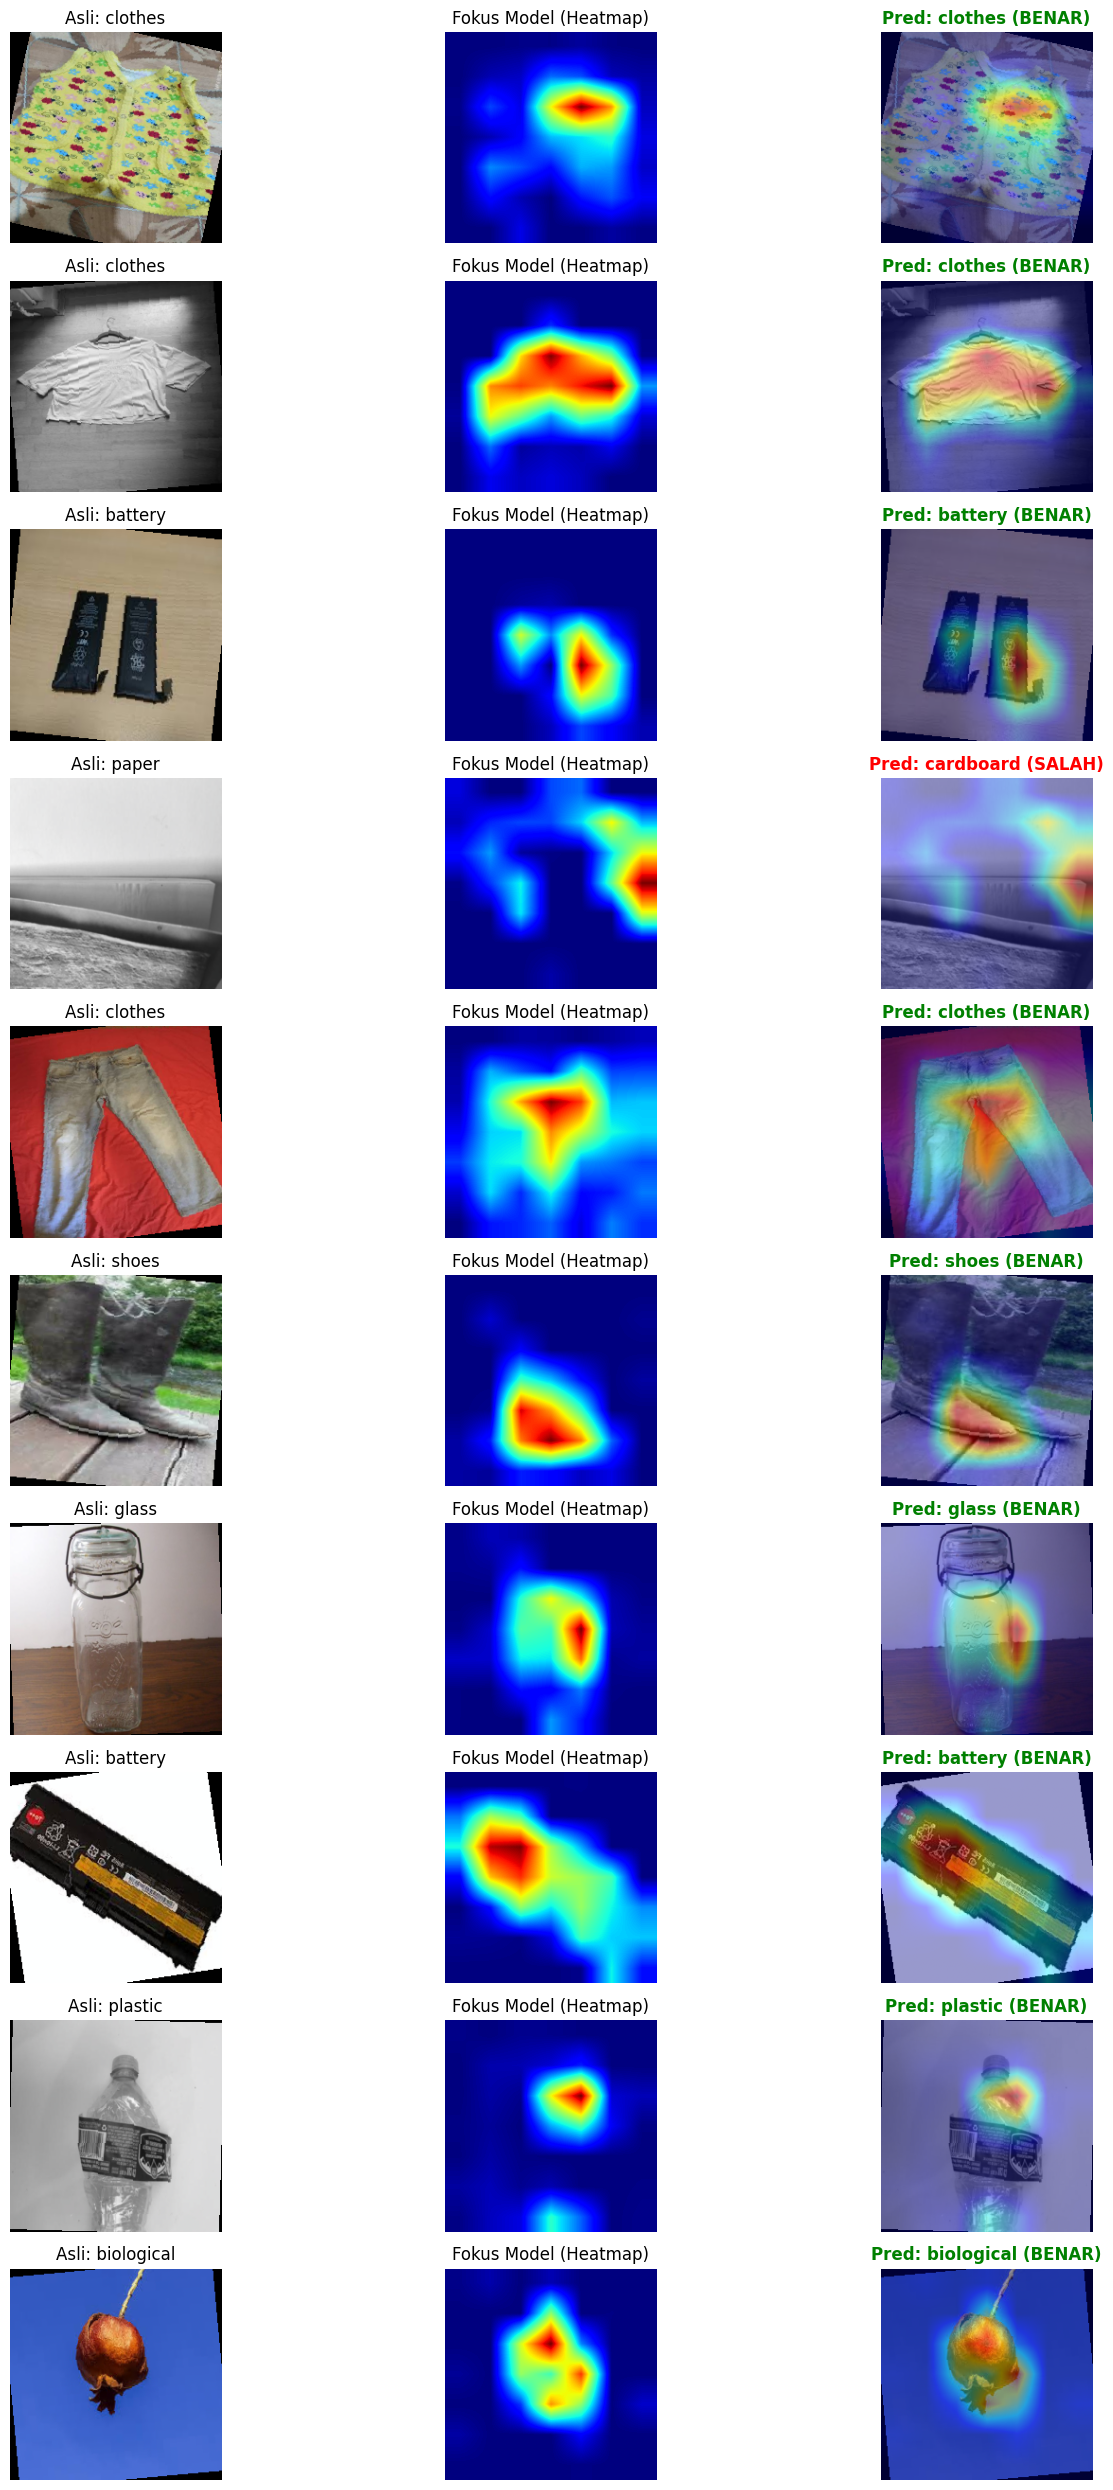

In [51]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import cv2  # OpenCV untuk resize heatmap agar halus

# --- 1. SETUP GRAD-CAM ---
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.gradients = None
        self.activations = None
        
        # Hook untuk menangkap output (activations) dan gradien dari layer target
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_heatmap(self, input_image, class_idx=None):
        # 1. Forward Pass
        output = self.model(input_image)
        
        # Jika class_idx tidak ditentukan, gunakan kelas dengan skor tertinggi (prediksi model)
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()
        
        # 2. Backward Pass (Hitung Gradien)
        self.model.zero_grad()
        score = output[0, class_idx]
        score.backward()
        
        # 3. Generate CAM
        # Global Average Pooling pada gradien
        weights = torch.mean(self.gradients, dim=[2, 3], keepdim=True)
        # Kalikan bobot dengan aktivasi
        cam = torch.sum(weights * self.activations, dim=1, keepdim=True)
        # ReLU (kita hanya tertarik pada pengaruh positif)
        cam = F.relu(cam)
        
        # Normalisasi heatmap ke range 0-1
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-7)
        
        return cam.squeeze().cpu().detach().numpy(), class_idx, output

# --- 2. FUNGSI UNTUK DENORMALISASI GAMBAR ---
# Agar gambar terlihat normal kembali (tidak aneh warnanya karena normalisasi ImageNet)
def denormalize(tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    img = tensor.permute(1, 2, 0).cpu().numpy()
    img = img * std + mean
    img = np.clip(img, 0, 1)
    return img

# --- 3. EKSEKUSI PADA 10 DATA TERAKHIR ---

# Inisialisasi GradCAM pada layer terakhir ResNet50 (layer4)
grad_cam = GradCAM(model, model.layer4[-1])
model.eval() 

# Ambil 10 indeks terakhir
total_data = len(test_dataset)
last_10_indices = range(total_data - 10, total_data)

plt.figure(figsize=(15, 25))

for i, idx in enumerate(last_10_indices):
    # Ambil gambar dan label
    image, label = test_dataset[idx]
    image_input = image.unsqueeze(0).to(device) # Tambah batch dim: [1, 3, 224, 224]
    
    # Generate Heatmap
    heatmap, pred_idx, scores = grad_cam.generate_heatmap(image_input)
    
    # Resize heatmap agar seukuran gambar asli (224x224)
    heatmap_resized = cv2.resize(heatmap, (224, 224))
    heatmap_colored = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_colored, cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB) / 255.0
    
    # Ambil gambar asli untuk background
    original_img = denormalize(image)
    
    # Gabungkan (Superimpose)
    superimposed_img = heatmap_colored * 0.4 + original_img * 0.6
    superimposed_img = np.clip(superimposed_img, 0, 1)
    
    # --- PLOTTING ---
    # Kolom 1: Gambar Asli
    plt.subplot(10, 3, 3*i + 1)
    plt.imshow(original_img)
    plt.title(f"Asli: {class_names[label]}")
    plt.axis('off')
    
    # Kolom 2: Heatmap Saja
    plt.subplot(10, 3, 3*i + 2)
    plt.imshow(heatmap_resized, cmap='jet')
    plt.title("Fokus Model (Heatmap)")
    plt.axis('off')
    
    # Kolom 3: Overlay (Tumpuk)
    plt.subplot(10, 3, 3*i + 3)
    plt.imshow(superimposed_img)
    
    # Cek apakah prediksi benar
    status = "BENAR" if pred_idx == label else "SALAH"
    color = "green" if status == "BENAR" else "red"
    
    plt.title(f"Pred: {class_names[pred_idx]} ({status})", color=color, fontweight='bold')
    plt.axis('off')

plt.tight_layout()
plt.show()